In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from scipy.stats import norm
import pyarrow.parquet as pq
import pandas as pd

# Loading in data and prepping for analysis

In [2]:
# Read in parquet file 
table = pq.read_table("/Users/167011/Documents/MQF/Thesis/Deribit_Data/deribit_options_2025-01-30_100k_rows.parquet")
# Convert to Panadas DataFrame
df = table.to_pandas()

# Seperate Option Type, Strike and Maturity
df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

# Define log-price to ensure positive values
df['log_price'] = np.log(df['underlying_price'])
# Define log-return
df['log_return'] = df['log_price'].diff().fillna(0)

# Define maturity in years
df['expiry'] = pd.to_datetime(df['expiry'])
reference_date = pd.to_datetime("2025-01-30")
df['time_to_maturity'] = (df['expiry'] - reference_date).dt.days / 252

# Group the DataFrame by 'time_stamp' and count unique 'time_to_maturity' values for each group
unique_counts = df.groupby('timestamp')['strike'].nunique()

# Identify the timestamp with the highest count of unique 'time_to_maturity' values
max_timestamp = unique_counts.idxmax()
max_count = unique_counts[max_timestamp]

# Snapshot where the count of unique 'time_to_maturity' values is highest
snapshot = df[(df['timestamp'] == max_timestamp) & (df['option_type'] == 'C')]

# Convert 'strike' to numeric
snapshot['strike'] = pd.to_numeric(snapshot['strike'], errors='coerce')

snapshot['mid_price'] = ((snapshot['best_bid_price'] + snapshot['best_ask_price']) / 2) # *snapshot['index_price']
snapshot['mark_price_usd'] = snapshot['mark_price']*snapshot['index_price']

snapshot = snapshot[['time_to_maturity', 'strike', 'mid_price', 'mark_price_usd', 'index_price']]

# print(snapshot)

options_df = snapshot.copy()

options_df['maturity'] = options_df['time_to_maturity']
options_df['mid_market'] = options_df['mid_price']
options_df['underlying'] = options_df['index_price']

options_df = options_df[['maturity', 'strike', 'mid_market', 'underlying']]

print(options_df)

options_df = options_df.astype({
    'maturity': 'float32',
    'strike': 'float32',
    'mid_market': 'float32',
    'underlying': 'float32'
})

       maturity  strike  mid_market  underlying
31951  0.226190  130000     0.02750   103740.81
31959  0.226190  150000     0.01150   103740.81
31961  0.226190  160000     0.00800   103740.81
31963  0.226190  170000     0.00600   103740.81
31965  0.226190  175000     0.00515   103740.81
31967  0.226190  180000     0.00455   103740.81
31969  0.226190  200000     0.00270   103740.81
31973  0.226190  250000     0.00140   103740.81
31975  0.226190  300000     0.00075   103740.81
31977  0.587302   20000     0.81650   103740.81
31979  0.587302   30000     0.72550   103740.81
31981  0.587302   40000     0.63525   103740.81
31983  0.587302   45000     0.59025   103740.81
31985  0.587302   50000     0.54575   103740.81
31987  0.587302   55000     0.50200   103740.81
31989  0.587302   60000     0.45875   103740.81
31991  0.587302   65000     0.41675   103740.81
31993  0.587302   70000     0.37600   103740.81
31995  0.587302   75000     0.33725   103740.81
31997  0.587302   80000     0.30075   10

/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_95546/427526649.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_95546/427526649.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot['strike'] = pd.to_numeric(snapshot['strike'], errors='coerce')
/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_95546/427526649.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# This is the Neural SDE model with a generative adversarial network calibration method

Epoch 0: T=0.2261904776096344: GenLoss=5812204.0000, T=0.5873016119003296: GenLoss=1442161024.0000, DiscLoss=2574555021312.0000
Epoch 50: T=0.2261904776096344: GenLoss=5555310.0000, T=0.5873016119003296: GenLoss=1470623232.0000, DiscLoss=-855931550171136.0000
Epoch 100: T=0.2261904776096344: GenLoss=6858801.5000, T=0.5873016119003296: GenLoss=1495719168.0000, DiscLoss=-12477268689420288.0000
Epoch 150: T=0.2261904776096344: GenLoss=7612538.5000, T=0.5873016119003296: GenLoss=1459038976.0000, DiscLoss=-62823191013228544.0000
Epoch 200: T=0.2261904776096344: GenLoss=5967528.5000, T=0.5873016119003296: GenLoss=1484918912.0000, DiscLoss=-177522680654725120.0000
Epoch 250: T=0.2261904776096344: GenLoss=6924386.0000, T=0.5873016119003296: GenLoss=1533817728.0000, DiscLoss=-387164569857949696.0000
Epoch 300: T=0.2261904776096344: GenLoss=7288478.0000, T=0.5873016119003296: GenLoss=1448037376.0000, DiscLoss=-714747566679392256.0000
Epoch 350: T=0.2261904776096344: GenLoss=6530764.0000, T=0.587

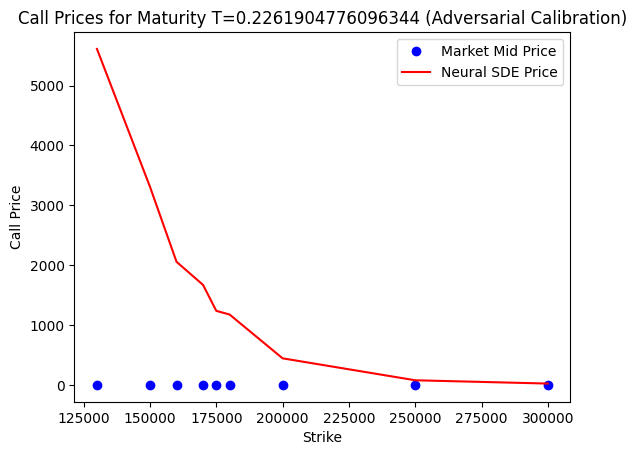

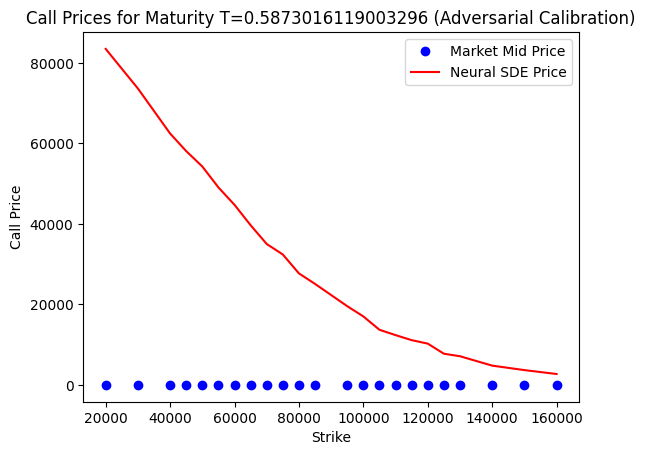

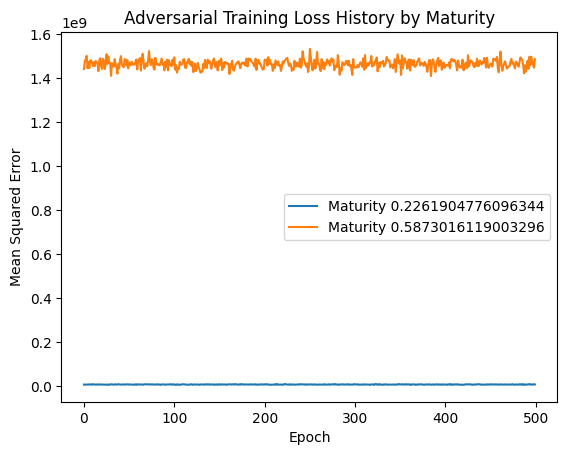

In [4]:
r = 0.01     # risk-free rate
sigma = 0.6  # baseline volatility
S0 = options_df['underlying'].iloc[0]  # initial asset price
 
# --------------------------
# 2. Define the neural network for the leverage function L(t, S)
# --------------------------
# Here we assume L is a function of time t and the current asset price S.
def build_leverage_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(2,)))  # inputs: [t, S]
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    # Use tanh then shift so that initial output is around 1.
    model.add(layers.Dense(1, activation='tanh'))
    model.add(layers.Lambda(lambda x: 1.0 + 0.2 * x))
    return model
 
# Get unique maturities from your options Dataframe
unique_maturities = options_df['maturity'].unique()
 
# Create a dictonary mapping each maturity to its own network
leverage_models = {}
for T in unique_maturities:
    leverage_models[T] = build_leverage_model()
 
# Create a dictonary of optimizers for each maturity-specific leverage model
optimizer_dict = {T: optimizers.Adam(learning_rate=0.01) for T in unique_maturities}
 
# --------------------------
# 3. Define the Neural SDE simulation (Euler–Maruyama)
# --------------------------
def simulate_S_paths(T, num_steps, num_paths, S0, sigma, leverage_model):
    """
    Simulate num_paths of S_t over [0, T] using Euler–Maruyama.
    The SDE is: dS_t = S_t * L(t, S_t) * sigma * dW_t.
    """
    dt = T / num_steps
    # Initialize S as a tensor of shape (num_paths,)
    S = tf.fill([num_paths], S0)
    t_val = 0.0
    # We'll record the terminal values S_T.
    for i in range(num_steps):
        t_val += dt
        # Prepare input for leverage model: a tensor of shape (num_paths, 2) with [t, S]
        t_tensor = tf.fill([num_paths, 1], t_val)
        S_tensor = tf.reshape(S, (-1, 1))
        inp = tf.concat([t_tensor, S_tensor], axis=1)
        # Compute L(t, S) via the neural network
        L_val = leverage_model(inp)  # shape (num_paths, 1)
        L_val = tf.reshape(L_val, [-1])
        # Sample dW ~ N(0, dt)
        dW = tf.random.normal([num_paths], mean=0.0, stddev=tf.sqrt(dt))
        # Euler update: S_{t+dt} = S_t + S_t * sigma * L(t,S_t) * dW
        S = S + S * sigma * L_val * dW
    return S
 
# --------------------------
# 4. Define option pricing via Monte Carlo simulation
# --------------------------
def monte_carlo_call_price(T, K, S0, r, sigma, leverage_model, num_steps=100, num_paths=5000):
    """
    Simulate paths for maturity T and compute the discounted call price.
    """
    # Simulate terminal asset values S_T
    S_T = simulate_S_paths(T, num_steps, num_paths, S0, sigma, leverage_model)
    # Compute payoff: (S_T - K)+
    payoff = tf.nn.relu(S_T - K)
    # Discount the average payoff
    price = tf.exp(-r * T) * tf.reduce_mean(payoff)
    return price
 
 
# --------------------------
# Build a discriminator network
# --------------------------
def build_discriminator():
    # Network takes as input a vector of features from an option
    model = models.Sequential()
    model.add(layers.Input(shape=(4,)))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(16, activation = 'relu'))
 
    # No activation function so output can be positive or negative. may consider changing this
    model.add(layers.Dense(1))
    return model
 
discriminator = build_discriminator()
disc_optimiser = optimizers.Adam(learning_rate=0.01)
 
 
# --------------------------
# Calibration loss
# --------------------------
 
num_epochs = 500
 
adv_loss_history = {T: [] for T in unique_maturities}
 
 
for epoch in range(num_epochs):
    # --- Step 1: Compute generator losses over the options dataset ---
    loss_total_by_T = {T: 0.0 for T in unique_maturities}
    count_by_T = {T: 0 for T in unique_maturities}
    gen_loss_dict = {}
 
    with tf.GradientTape(persistent=True) as tape_gen:
        # Loop over each option in the DataFrame
        for idx, row in options_df.iterrows():
            T = float(row['maturity'])
            K = float(row['strike'])
            market_price = float(row['mid_market'])
            model_net = leverage_models[T]
            # Compute model price via Monte Carlo simulation.
            model_price = monte_carlo_call_price(T, K, S0, r, sigma, model_net,
                                                 num_steps=100, num_paths=1000)
            # Define the generator loss (squared error)
            option_loss = tf.square(model_price - market_price)
            loss_total_by_T[T] += option_loss
            count_by_T[T] += 1
 
        # Average the loss for each maturity group
        for T in unique_maturities:
            if count_by_T[T] > 0:
                loss_total_by_T[T] /= count_by_T[T]
            gen_loss_dict[T] = loss_total_by_T[T]
 
    # Update generator (leverage models)
    for T in unique_maturities:
        model = leverage_models[T]
        grads_gen = tape_gen.gradient(gen_loss_dict[T], model.trainable_variables)
        optimizer_dict[T].apply_gradients(zip(grads_gen, model.trainable_variables))
        adv_loss_history[T].append(gen_loss_dict[T].numpy())
    del tape_gen
 
    # --- Step 2: Update the discriminator ---
    disc_loss_list = []
    with tf.GradientTape() as tape_disc:
        # For each option, compute the adversarial loss using the discriminator.
        for idx, row in options_df.iterrows():
            T = float(row['maturity'])
            K = float(row['strike'])
            market_price = float(row['mid_market'])
            model_net = leverage_models[T]
            model_price = monte_carlo_call_price(T, K, S0, r, sigma, model_net,
                                                 num_steps=100, num_paths=1000)
            # Build discriminator input (make sure to use training=True)
            disc_input = tf.convert_to_tensor([[T, K, model_price, market_price]], dtype=tf.float32)
            weight = discriminator(disc_input, training=True)
            # Adversarial loss for discriminator: we want to maximize the discrepancy,
            # so we minimize the negative of (weight * squared error).
            option_disc_loss = - weight * tf.square(model_price - market_price)
            disc_loss_list.append(option_disc_loss)
        if disc_loss_list:
            total_disc_loss = tf.reduce_mean(tf.stack(disc_loss_list))
        else:
            total_disc_loss = 0.0
    disc_grads = tape_disc.gradient(total_disc_loss, discriminator.trainable_variables)
    # Only apply gradients if they are not all None:
    if disc_grads is not None and any(g is not None for g in disc_grads):
        disc_optimiser.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    del tape_disc
 
    if epoch % 50 == 0:
        losses_str = ", ".join([f"T={T}: GenLoss={gen_loss_dict[T].numpy():.4f}" for T in unique_maturities])
        print(f"Epoch {epoch}: {losses_str}, DiscLoss={total_disc_loss.numpy():.4f}")
 
 
# --------------------------
# 6. Compare calibrated model prices with market data
# --------------------------
model_prices = []
for idx, row in options_df.iterrows():
    T = float(row['maturity'])
    K = float(row['strike'])
    model_net = leverage_models[T]
    price = monte_carlo_call_price(T, K, S0, r, sigma, model_net, num_steps=100, num_paths=5000)
    model_prices.append(price.numpy())
options_df['model_price'] = model_prices
 
# Plot calibration results (market vs. model prices) for each maturity.
for T_val in options_df['maturity'].unique():
    subset = options_df[options_df['maturity'] == T_val]
    plt.figure()
    plt.plot(subset['strike'], subset['mid_market'], 'bo', label='Market Mid Price')
    plt.plot(subset['strike'], subset['model_price'], 'r-', label='Neural SDE Price')
    plt.title(f'Call Prices for Maturity T={T_val} (Adversarial Calibration)')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.legend()
    plt.show()
 
# Plot training loss history for each maturity.
plt.figure()
for T in unique_maturities:
    plt.plot(adv_loss_history[T], label=f'Maturity {T}')
plt.title("Adversarial Training Loss History by Maturity")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

plt.show()

